### Modeling portion

In [1]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from tqdm import tqdm
import warnings
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import sklearn

In [2]:
pd.set_option("display.max_columns", 100)

In [3]:
data = pd.read_csv('scraped\data\expensive_high_mileage_removed.csv')

In [4]:
data

,city,state,latitude,longitude,dealerReviewRating,dealerReviewCount,city.1,state.1,vin,year,make,model,trim,subTrim,topOptions,newTopOptions,mileage,listPrice,currentPrice,exteriorColor,interiorColor,engine,displacement,drivetype,transmission,fuel,mpgCity,mpgHighway,bodytype,vehicleCondition,cabType,bedLength,imageCount,oneOwner,noAccidents,serviceRecords,personalUse
0,New York,NY,41.764880,-88.19182,5,62,Naperville,IL,19UUB2F7XFA009711,2015,Acura,TLX,Advance,Unspecified,10,10,37182,20926.0,20926.0,Black,Black,6 Cyl,3.5 L,FWD,Automatic,Gasoline,21.0,34.0,Sedan,Used,Unspecified,Unspecified,34,True,True,True,True
1,New York,NY,43.037020,-88.15128,5,66,Brookfield,WI,5J8YD4H55JL023242,2018,Acura,MDX,Technology,Unspecified,10,10,8956,38500.0,38500.0,White,Brown,6 Cyl,3.5 L,AWD,Automatic,Gasoline,18.0,26.0,SUV,Used,Unspecified,Unspecified,33,True,True,True,True
2,New York,NY,43.037020,-88.15128,5,66,Brookfield,WI,19UUB2F53FA012870,2015,Acura,TLX,Technology,Unspecified,10,10,36619,19999.0,19999.0,Brown,Tan,6 Cyl,3.5 L,FWD,Automatic,Gasoline,21.0,34.0,Sedan,Used,Unspecified,Unspecified,31,True,True,True,True
3,New York,NY,36.843240,-76.08293,5,79,Virginia Beach,VA,5J8TB4H51HL017688,2017,Acura,RDX,Technology,Unspecified,10,10,38593,26000.0,26000.0,Silver,Black,6 Cyl,3.5 L,AWD,Automatic,Gasoline,19.0,27.0,SUV,Used,Unspecified,Unspecified,37,True,True,True,True
4,New York,NY,36.843240,-76.08293,5,79,Virginia Beach,VA,5J8YD3H53HL002006,2017,Acura,MDX,Technology,Unspecified,10,10,29400,31500.0,31500.0,Gray,Black,6 Cyl,3.5 L,FWD,Automatic,Gasoline,19.0,27.0,SUV,Used,Unspecified,Unspecified,38,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34594,Daly City,CA,40.525590,-105.07755,5,2,Fort Collins,CO,YV4A22PK4H1137110,2017,Volvo,XC90,T6 Momentum,Unspecified,10,10,26728,41500.0,41500.0,Gray,Black,4 Cyl,2.0 L,AWD,Automatic,Gasoline,20.0,25.0,SUV,Used,Unspecified,Unspecified,0,True,True,True,True
34595,Daly City,CA,39.728697,-104.98741,5,67,Denver,CO,YV449MRU9H2127119,2017,Volvo,XC60,T6 Inscription,Unspecified,10,10,32856,31500.0,31500.0,Blue,Black,4 Cyl,2.0 L,AWD,Automatic,Gasoline,20.0,29.0,SUV,Used,Unspecified,Unspecified,27,True,True,True,True
34596,Daly City,CA,34.146460,-118.10844,0,0,Pasadena,CA,7JRA22TK9KG015065,2019,Volvo,S60,T6 Momentum,Unspecified,10,10,12200,37998.0,37998.0,Gray,Black,4 Cyl,2.0 L,AWD,Automatic,Gasoline,24.0,36.0,Sedan,Used,Unspecified,Unspecified,0,True,True,True,False
34597,Daly City,CA,39.728697,-104.98741,5,67,Denver,CO,YV4A22PLXH1149688,2017,Volvo,XC90,T6 Inscription,Unspecified,10,10,38256,43500.0,43500.0,Black,Yellow,4 Cyl,2.0 L,AWD,Automatic,Gasoline,20.0,25.0,SUV,Used,Unspecified,Unspecified,18,True,True,True,False


In [5]:
# Removing a few to make sure that small cell sizes don't exist
data.drop(['trim', 'subTrim', 'displacement', 'vehicleCondition', 'cabType', 'bedLength',
          'city.1', 'state.1', 'vin', 'latitude', 'longitude', 'listPrice', 'interiorColor', 'exteriorColor', 'dealerReviewCount',
          'topOptions', 'newTopOptions', 'bodytype'], axis = 1, inplace = True)

In [6]:
data.groupby(['city', 'state', 'make',
       'model', 'engine', 'drivetype', 'transmission', 'fuel',
       'oneOwner', 'noAccidents', 'serviceRecords',
       'personalUse']).count()#.iloc[:,0]

dealerReviewRating  \
city     state make   model    engine drivetype transmission fuel     oneOwner noAccidents serviceRecords personalUse                       
Addison  TX    Acura  ILX      4 Cyl  FWD       Automatic    Gasoline False    True        True           False                        14   
                                                                                                          True                          1   
                                                                      True     True        True           False                         2   
                                                                                                          True                          4   
                      MDX      6 Cyl  AWD       Automatic    Gasoline False    True        True           False                         5   
...                                                                                                                                   ...   
New York NY    Toyota Yaris    4 Cyl  FWD       Automatic    Gasoline True     True        True           False                         1   
                                                                                                          True                          2   
                      Yaris iA 4 Cyl  FWD       Automatic    Gasoline True     True        False          False                         1   
                                                                                           True           True                          2   
                                                Manual       Gasoline True     True        True           True                          1   

                                                                                                                       year  \
city     state make   model    engine drivetype transmission fuel     oneOwner noAccidents serviceRecords personalUse         
Addison  TX    Acura  ILX      4 Cyl  FWD       Automatic    Gasoline False    True        True           False          14   
                                                                                                          True            1   
                                                                      True     True        True           False           2   
                                                                                                          True            4   
                      MDX      6 Cyl  AWD       Automatic    Gasoline False    True        True           False           5   
...                                                                                                                     ...   
New York NY    Toyota Yaris    4 Cyl  FWD       Automatic    Gasoline True     True        True           False           1   
                                                                                                          True            2   
                      Yaris iA 4 Cyl  FWD       Automatic    Gasoline True     True        False          False           1   
                                                                                           True           True            2   
                                                Manual       Gasoline True     True        True           True            1   

                                                                                                                       mileage  \
city     state make   model    engine drivetype transmission fuel     oneOwner noAccidents serviceRecords personalUse            
Addison  TX    Acura  ILX      4 Cyl  FWD       Automatic    Gasoline False    True        True           False             14   
                                                                                                          True               1   
                                                                      True     True        True           False  

In [7]:
data = data.groupby(['city', 'state', 'make',
       'model', 'engine', 'drivetype', 'transmission', 'fuel',
       'oneOwner', 'noAccidents', 'serviceRecords',
       'personalUse']).filter(lambda x: x['dealerReviewRating'].count() < 3)

In [8]:
# Setting up dummies
# One hot encoding
model_data = pd.get_dummies(data, columns = ['city', 'state', 'make', 'model', 
       'engine', 'drivetype', 'transmission', 'fuel', 'oneOwner', 'noAccidents', 'serviceRecords',
       'personalUse'], drop_first = True)

In [9]:
model_data

,dealerReviewRating,year,mileage,currentPrice,mpgCity,mpgHighway,imageCount,city_Daly City,city_New York,state_NY,state_TX,make_Audi,make_BMW,make_Buick,make_Cadillac,make_Ford,make_Honda,make_Hyundai,make_Jeep,make_Kia,make_Lexus,make_Mini,make_Nissan,make_Porsche,make_Ram,make_Subaru,make_Toyota,make_Volkswagen,make_Volvo,model_2 Series,model_2500,model_3 Series,model_3500,model_4 Series,model_4Runner,model_5 Series,model_6 Series,model_7 Series,model_718 Boxster,model_718 Cayman,model_911,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_ATS,model_Accent,model_Accord,...,model_Sportage,model_Stinger,model_TLX,model_TT,model_Tacoma,model_Taurus,model_Tiguan,model_Titan,model_Transit,model_Tucson,model_Tundra,model_UX,model_Veloster,model_Verano,model_Versa,model_WRX,model_Wrangler,model_X1,model_X2,model_X3,model_X4,model_X5,model_X6,model_XC60,model_XC90,model_XT5,model_XTS,model_Yaris,model_Yaris iA,model_e-tron,model_i3,engine_3 Cyl,engine_4 Cyl,engine_6 Cyl,engine_8 Cyl,engine_Electric,drivetype_AWD,drivetype_FWD,drivetype_RWD,drivetype_Unspecified,transmission_Manual,transmission_Unspecified,fuel_Electric,fuel_Flexible-Fuel,fuel_Gasoline,fuel_Hybrid,oneOwner_True,noAccidents_True,serviceRecords_True,personalUse_True
305,4,2016,28417,25995.0,18.0,26.0,32,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0
317,5,2016,47753,23991.0,20.0,30.0,52,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1
346,5,2019,7003,37485.0,21.0,26.0,25,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1
357,0,2016,24418,16161.0,25.0,35.0,27,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1
408,5,2017,37987,15989.0,25.0,35.0,46,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34575,4,2018,21124,47425.0,20.0,27.0,32,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
34577,4,2017,40007,31775.0,22.0,26.0,32,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1
34578,5,2018,39862,24680.0,22.0,33.0,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0
34579,0,2018,21951,41600.0,22.0,28.0,34,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1


In [10]:
# Initial split
y = model_data.loc[:,'currentPrice']
x = model_data.drop('currentPrice', axis = 1)

### Scaling

In [11]:
scaler = preprocessing.MinMaxScaler()
scaled_x = scaler.fit_transform(x)
scaled_x = pd.DataFrame(scaled_x, columns=x.columns)

In [12]:
scaled_x

,dealerReviewRating,year,mileage,mpgCity,mpgHighway,imageCount,city_Daly City,city_New York,state_NY,state_TX,make_Audi,make_BMW,make_Buick,make_Cadillac,make_Ford,make_Honda,make_Hyundai,make_Jeep,make_Kia,make_Lexus,make_Mini,make_Nissan,make_Porsche,make_Ram,make_Subaru,make_Toyota,make_Volkswagen,make_Volvo,model_2 Series,model_2500,model_3 Series,model_3500,model_4 Series,model_4Runner,model_5 Series,model_6 Series,model_7 Series,model_718 Boxster,model_718 Cayman,model_911,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_ATS,model_Accent,model_Accord,model_Allroad,...,model_Sportage,model_Stinger,model_TLX,model_TT,model_Tacoma,model_Taurus,model_Tiguan,model_Titan,model_Transit,model_Tucson,model_Tundra,model_UX,model_Veloster,model_Verano,model_Versa,model_WRX,model_Wrangler,model_X1,model_X2,model_X3,model_X4,model_X5,model_X6,model_XC60,model_XC90,model_XT5,model_XTS,model_Yaris,model_Yaris iA,model_e-tron,model_i3,engine_3 Cyl,engine_4 Cyl,engine_6 Cyl,engine_8 Cyl,engine_Electric,drivetype_AWD,drivetype_FWD,drivetype_RWD,drivetype_Unspecified,transmission_Manual,transmission_Unspecified,fuel_Electric,fuel_Flexible-Fuel,fuel_Gasoline,fuel_Hybrid,oneOwner_True,noAccidents_True,serviceRecords_True,personalUse_True
0,0.8,0.666667,0.259170,0.120000,0.213115,0.415584,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.666667,0.435520,0.133333,0.245902,0.675325,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2,1.0,0.916667,0.063869,0.140000,0.213115,0.324675,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0.0,0.666667,0.222699,0.166667,0.286885,0.350649,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
4,1.0,0.750000,0.346451,0.166667,0.286885,0.597403,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3174,0.8,0.833333,0.192656,0.133333,0.221311,0.415584,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [13]:
x

,dealerReviewRating,year,mileage,mpgCity,mpgHighway,imageCount,city_Daly City,city_New York,state_NY,state_TX,make_Audi,make_BMW,make_Buick,make_Cadillac,make_Ford,make_Honda,make_Hyundai,make_Jeep,make_Kia,make_Lexus,make_Mini,make_Nissan,make_Porsche,make_Ram,make_Subaru,make_Toyota,make_Volkswagen,make_Volvo,model_2 Series,model_2500,model_3 Series,model_3500,model_4 Series,model_4Runner,model_5 Series,model_6 Series,model_7 Series,model_718 Boxster,model_718 Cayman,model_911,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_ATS,model_Accent,model_Accord,model_Allroad,...,model_Sportage,model_Stinger,model_TLX,model_TT,model_Tacoma,model_Taurus,model_Tiguan,model_Titan,model_Transit,model_Tucson,model_Tundra,model_UX,model_Veloster,model_Verano,model_Versa,model_WRX,model_Wrangler,model_X1,model_X2,model_X3,model_X4,model_X5,model_X6,model_XC60,model_XC90,model_XT5,model_XTS,model_Yaris,model_Yaris iA,model_e-tron,model_i3,engine_3 Cyl,engine_4 Cyl,engine_6 Cyl,engine_8 Cyl,engine_Electric,drivetype_AWD,drivetype_FWD,drivetype_RWD,drivetype_Unspecified,transmission_Manual,transmission_Unspecified,fuel_Electric,fuel_Flexible-Fuel,fuel_Gasoline,fuel_Hybrid,oneOwner_True,noAccidents_True,serviceRecords_True,personalUse_True
305,4,2016,28417,18.0,26.0,32,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0
317,5,2016,47753,20.0,30.0,52,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1
346,5,2019,7003,21.0,26.0,25,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1
357,0,2016,24418,25.0,35.0,27,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1
408,5,2017,37987,25.0,35.0,46,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34575,4,2018,21124,20.0,27.0,32,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
34577,4,2017,40007,22.0,26.0,32,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1
34578,5,2018,39862,22.0,33.0,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0
34579,0,2018,21951,22.0,28.0,34,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1


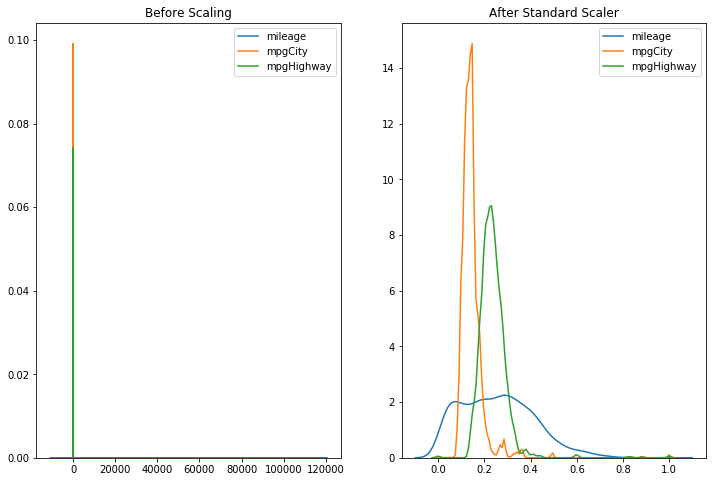

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8))

ax1.set_title('Before Scaling')
sns.kdeplot(x['mileage'], ax=ax1)
sns.kdeplot(x['mpgCity'], ax=ax1)
sns.kdeplot(x['mpgHighway'], ax=ax1)
ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_x['mileage'], ax=ax2)
sns.kdeplot(scaled_x['mpgCity'], ax=ax2)
sns.kdeplot(scaled_x['mpgHighway'], ax=ax2)
plt.show()

In [15]:
# Split into training and test set
# Stratifying to make sure the split of phisihng/valid stays equal across train/test split.
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size = 0.3, random_state=2)

In [16]:
# Making sure nothing went wrong with the split.
np.mean(y_train), np.mean(y_test)

(29630.251235955056, 29479.12578616352)

In [95]:
x_train

,dealerReviewRating,year,mileage,mpgCity,mpgHighway,imageCount,city_Daly City,city_New York,state_NY,state_TX,make_Audi,make_BMW,make_Buick,make_Cadillac,make_Ford,make_Honda,make_Hyundai,make_Jeep,make_Kia,make_Lexus,make_Mini,make_Nissan,make_Porsche,make_Ram,make_Subaru,make_Toyota,make_Volkswagen,make_Volvo,model_2 Series,model_2500,model_3 Series,model_3500,model_4 Series,model_4Runner,model_5 Series,model_6 Series,model_7 Series,model_718 Boxster,model_718 Cayman,model_911,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_ATS,model_Accent,model_Accord,model_Allroad,...,model_Sportage,model_Stinger,model_TLX,model_TT,model_Tacoma,model_Taurus,model_Tiguan,model_Titan,model_Transit,model_Tucson,model_Tundra,model_UX,model_Veloster,model_Verano,model_Versa,model_WRX,model_Wrangler,model_X1,model_X2,model_X3,model_X4,model_X5,model_X6,model_XC60,model_XC90,model_XT5,model_XTS,model_Yaris,model_Yaris iA,model_e-tron,model_i3,engine_3 Cyl,engine_4 Cyl,engine_6 Cyl,engine_8 Cyl,engine_Electric,drivetype_AWD,drivetype_FWD,drivetype_RWD,drivetype_Unspecified,transmission_Manual,transmission_Unspecified,fuel_Electric,fuel_Flexible-Fuel,fuel_Gasoline,fuel_Hybrid,oneOwner_True,noAccidents_True,serviceRecords_True,personalUse_True
1688,1.0,0.916667,0.173978,0.140000,0.213115,0.506494,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2331,1.0,0.583333,0.274347,0.140000,0.221311,0.233766,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2756,1.0,0.750000,0.129553,0.140000,0.229508,0.259740,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
2380,1.0,0.916667,0.129991,0.146667,0.245902,0.298701,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1248,1.0,0.750000,0.637935,0.106667,0.180328,0.129870,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,1.0,0.750000,0.259216,0.126667,0.213115,0.389610,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### Modeling

#### 1. Linear, Lasso, and Ridge Regression

#### Lasso

Through trial and error, I narrowed down the potential best values of alpha. Below is the final tuned best choice.

In [32]:
warnings.filterwarnings(action='ignore')
lasso_params = {'alpha':np.linspace(0.001, 0.1, 15), 'max_iter':[2000]}

lasso_cv = GridSearchCV(linear_model.Lasso(), param_grid=lasso_params, cv = 5)
lasso_cv.fit(x_train, y_train)

print("Tuned Lasso Regression Alpha Parameter: {}".format(lasso_cv.best_params_)) 

Tuned Lasso Regression Alpha Parameter: {'alpha': 0.1, 'max_iter': 2000}


In [33]:
# help from datacamp
# Predict on the test set and compute metrics
y_pred_lasso = lasso_cv.predict(x_test)
r2_lasso = lasso_cv.score(x_test, y_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print("Tuned Lasso R^2 on holdout set: {}".format(r2_lasso))
print("Tuned Lasso RMSE on holdout set: {}".format(np.sqrt(mse_lasso)))

Tuned Lasso R^2 on holdout set: 0.8508085441298007
Tuned Lasso RMSE on holdout set: 6221.305415917703


In [34]:
comparison = pd.DataFrame(y_test)
comparison['predPrice_Lasso']  = y_pred_lasso
comparison['Lasso'] = comparison['currentPrice'] - comparison['predPrice_Lasso']
comparison

,currentPrice,predPrice_Lasso,Lasso
22285,30981.0,34237.734502,-3256.734502
7848,18680.0,19970.648984,-1290.648984
27966,20995.0,22877.133116,-1882.133116
19624,17000.0,24386.766119,-7386.766119
7130,15232.0,15523.848183,-291.848183
...,...,...,...
13089,18995.0,16707.661914,2287.338086
8722,13995.0,16786.587148,-2791.587148
19141,24900.0,25013.867001,-113.867001
16230,24891.0,28985.910002,-4094.910002


In [36]:
max(comparison['Lasso']), min(abs(comparison['Lasso']))

(74064.44599403918, 6.377829441364156)

As a sanity check, above are some comparisons of what the model predicted vs the true values in the holdout set. They all seem to be within several thousand dollars of the true price. This is promising. Just for fun, the maximum absolute difference between the prediction and the true value is over 76,000 USD! Not good. The minimum is however just under 5 cents. Hopefully with further modeling, this range can be closed and skewed to the minimum.

#### Ridge

In [37]:
warnings.filterwarnings(action='ignore', category=FutureWarning)
ridge_params = {'alpha':np.linspace(0, 10, 35), 'max_iter':[3000]}

ridge_cv = GridSearchCV(linear_model.Ridge(), param_grid=ridge_params, cv = 5)
ridge_cv.fit(x_train, y_train)

print("Tuned Ridge Regression Parameters: {}".format(ridge_cv.best_params_)) 

Tuned Ridge Regression Parameters: {'alpha': 0.29411764705882354, 'max_iter': 3000}


In [38]:
# help from datacamp
# Predict on the test set and compute metrics
y_pred_Ridge = ridge_cv.predict(x_test)
r2_Ridge = ridge_cv.score(x_test, y_test)
mse_Ridge = mean_squared_error(y_test, y_pred_Ridge)

print("Tuned Ridge R^2 on holdout set: {}".format(r2_Ridge))
print("Tuned Ridge RMSE on holdout set: {}".format(np.sqrt(mse_Ridge)))

Tuned Ridge R^2 on holdout set: 0.846946261319649
Tuned Ridge RMSE on holdout set: 6301.319747663301


In [39]:
comparison['predPrice_Ridge']  = y_pred_Ridge
comparison['Ridge'] = comparison['currentPrice'] - comparison['predPrice_Ridge']

#### 2. Elastic Net

In [40]:
# Create the hyperparameter grid
l1 = np.linspace(0, 1, 5)
alpha = np.linspace(0.1, 10, 15)
param_grid = {'l1_ratio':l1, 'alpha':alpha}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(x_train, y_train)

# Predict on the test set and compute metrics
y_pred_ElasticNet = gm_cv.predict(x_test)
r2_ElasticNet = gm_cv.score(x_test, y_test)
mse_ElasticNet = mean_squared_error(y_test, y_pred_ElasticNet)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2_ElasticNet))
print("Tuned ElasticNet RMSE: {}".format(np.sqrt(mse_ElasticNet)))

Tuned ElasticNet l1 ratio: {'alpha': 0.8071428571428572, 'l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.8504845766053674
Tuned ElasticNet RMSE: 6228.0564993819435


In [41]:
comparison['predPrice_ElasticNet']  = y_pred_ElasticNet
comparison['ElasticNet'] = comparison['currentPrice'] - comparison['predPrice_ElasticNet']

In [42]:
comparison.columns = ['currentPrice', 'predPrice_Lasso', 'Lasso Diff', 'predPrice_ElasticNet', 'ElasticNet Diff', 'predPrice_Ridge', 'Ridge Diff']

In [106]:
comparison

,currentPrice,predPrice_Lasso,Lasso Diff,predPrice_ElasticNet,ElasticNet Diff,predPrice_Ridge,Ridge Diff
22285,30981.0,34646.901265,-3665.901265,34982.309500,-4001.309500,34644.770246,-3663.770246
7848,18680.0,19032.351837,-352.351837,18501.502989,178.497011,19035.728892,-355.728892
27966,20995.0,22845.849454,-1850.849454,21838.145210,-843.145210,22425.138210,-1430.138210
19624,17000.0,24429.904672,-7429.904672,24787.022150,-7787.022150,24194.237635,-7194.237635
7130,15232.0,15543.647535,-311.647535,17227.201484,-1995.201484,15952.557953,-720.557953
...,...,...,...,...,...,...,...
5434,26994.0,30367.269587,-3373.269587,31181.491674,-4187.491674,30509.023059,-3515.023059
3839,14999.0,16956.150435,-1957.150435,16050.450937,-1051.450937,16819.256919,-1820.256919
7022,59196.0,52592.634950,6603.365050,51732.124874,7463.875126,52340.410482,6855.589518
33969,9990.0,5649.819679,4340.180321,5854.288917,4135.711083,5940.172535,4049.827465


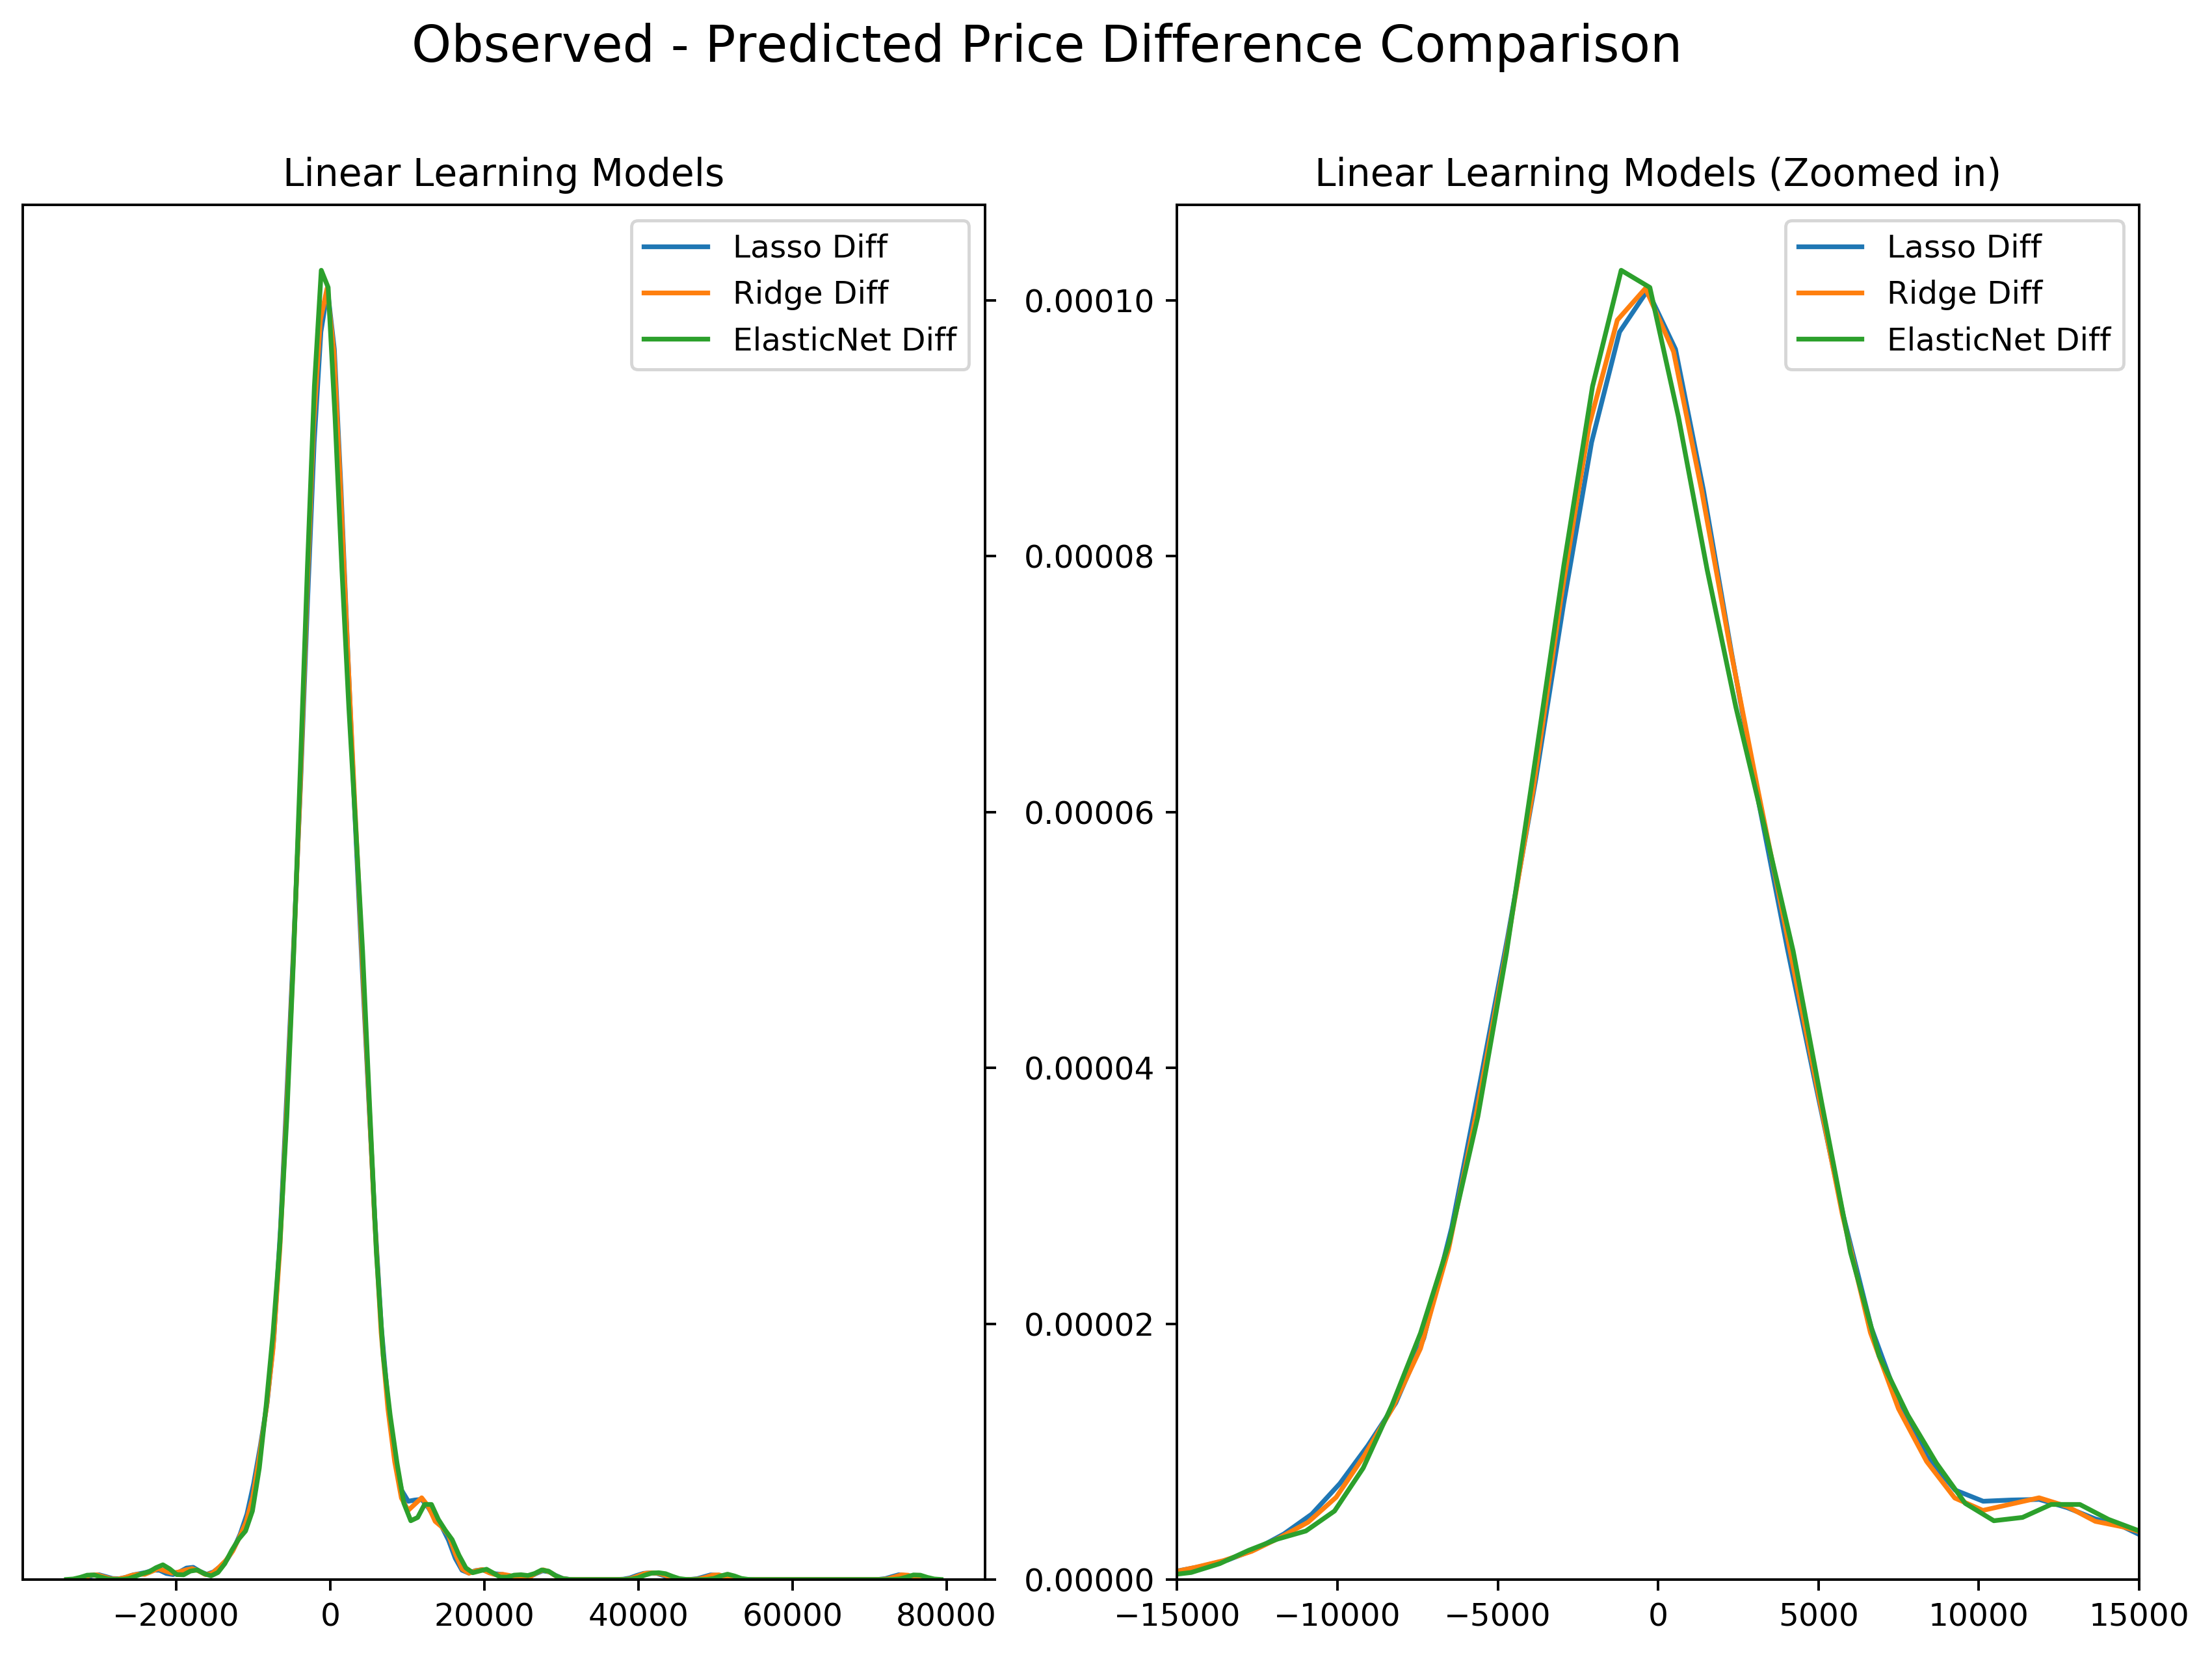

In [43]:
#plt.style.available
#plt.style.use('ggplot')


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8), dpi = 350)
fig.suptitle('Observed - Predicted Price Difference Comparison', fontsize=16)

ax1.set_title('Linear Learning Models')
sns.kdeplot(comparison['Lasso Diff'], ax=ax1)
sns.kdeplot(comparison['Ridge Diff'], ax=ax1)
sns.kdeplot(comparison['ElasticNet Diff'], ax=ax1)
ax1.set_yticklabels('')
ax1.yaxis.tick_right()


ax2.set_title('Linear Learning Models (Zoomed in)')
sns.kdeplot(comparison['Lasso Diff'], ax=ax2)
sns.kdeplot(comparison['Ridge Diff'], ax=ax2)
sns.kdeplot(comparison['ElasticNet Diff'], ax=ax2)
plt.xlim(-15000, 15000)
    
plt.show()

As is clear from the graph above, showing the diferences between the predicted values and observed values of the holdout set, the three linear methods did comparitively the same. Although Ridge had the lowest RMSE score, which makes it the best model so far. Another observation is that the curves are symmentrical meaning there is no evidence of bias in the model. The goal now would be to use other methods to make the curves 'skinnier' without shifting their centers. Baseline is established.

### Random Forest

In [44]:
params_rf = {'bootstrap': [True, False],
 'max_depth': [10, 20, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]
            }
rf = RandomForestRegressor(random_state=2)

grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       cv=5,
                       verbose=1,
                       n_jobs=-1)

grid_rf.fit(x_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 599 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   33.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True, False],
        

In [45]:
# Predict on the test set and compute metrics
y_pred_RF = grid_rf.predict(x_test)
score_RF = grid_rf.score(x_test, y_test)
mse_RF = mean_squared_error(y_test, y_pred_RF)

print("Tuned RF score: {}".format(score_RF))
print("Tuned RF RMSE: {}".format(np.sqrt(mse_RF)))

Tuned RF score: 0.8481520622247014
Tuned RF RMSE: 6276.448870828592


In [46]:
comparison['predPrice_RF']  = y_pred_RF
comparison['RF Diff'] = comparison['currentPrice'] - comparison['predPrice_RF']
comparison
#Writing the new data: only one unique VIN, no currentPrice is 0, expensive and high mileage cars removed
#data.to_csv(r'scraped/data/comparison.csv', index = True)

,currentPrice,predPrice_Lasso,Lasso Diff,predPrice_ElasticNet,ElasticNet Diff,predPrice_Ridge,Ridge Diff,predPrice_RF,RF Diff
22285,30981.0,34237.734502,-3256.734502,34565.051323,-3584.051323,34233.970667,-3252.970667,30181.475000,799.525000
7848,18680.0,19970.648984,-1290.648984,19347.985350,-667.985350,19931.449689,-1251.449689,22999.666667,-4319.666667
27966,20995.0,22877.133116,-1882.133116,21855.631576,-860.631576,22434.013283,-1439.013283,20010.033333,984.966667
19624,17000.0,24386.766119,-7386.766119,24761.009251,-7761.009251,24125.165975,-7125.165975,20678.825000,-3678.825000
7130,15232.0,15523.848183,-291.848183,17273.793049,-2041.793049,15950.880432,-718.880432,18160.350000,-2928.350000
...,...,...,...,...,...,...,...,...,...
13089,18995.0,16707.661914,2287.338086,17102.442778,1892.557222,16724.669127,2270.330873,19453.933333,-458.933333
8722,13995.0,16786.587148,-2791.587148,14359.729698,-364.729698,16229.674386,-2234.674386,23055.741667,-9060.741667
19141,24900.0,25013.867001,-113.867001,24916.683063,-16.683063,25044.003653,-144.003653,24947.350000,-47.350000
16230,24891.0,28985.910002,-4094.910002,28913.433114,-4022.433114,29067.550664,-4176.550664,28866.008333,-3975.008333


### XGBoost

In [17]:
comparison = pd.read_csv('scraped\data\comparison.csv')

In [18]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# courtesy of the above post

xgb1 = XGBRegressor(seed=2)

In [19]:
param_test1 = {
 'max_depth':range(3,15),
 'min_child_weight':range(1,10)
}

gsearch1 = GridSearchCV(estimator = xgb1, 
                        scoring='neg_mean_squared_error',
                        param_grid = param_test1,
                        n_jobs=4,
                        iid=False, 
                        cv=3, 
                        verbose = 1)

gsearch1.fit(x_train, y_train)

gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 324 out of 324 | elapsed:  3.8min finished
C:\Users\maksym\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:52:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'max_depth': 8, 'min_child_weight': 1}, -33341927.81067704)

In [20]:
y_pred_xgb = gsearch1.predict(x_train)
mse_xgb1 = mean_squared_error(y_train, y_pred_xgb)
print("Tuned (in-progress) RMSE: {}".format(np.sqrt(mse_xgb1)))

Tuned (in-progress) RMSE: 2146.5153461826767


In [21]:

param_test2 = {
 'gamma':[i/3 for i in range(0,50)],
 'max_depth':[8],
 'min_child_weight':[1]
}

gsearch2 = GridSearchCV(estimator = xgb1, 
                        scoring='neg_mean_squared_error',
                        param_grid = param_test2,
                        n_jobs=4,
                        iid=False, 
                        cv=3, 
                        verbose = 1)

gsearch2.fit(x_train, y_train)

gsearch2.best_params_, gsearch2.best_score_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  1.8min finished
C:\Users\maksym\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'gamma': 0.0, 'max_depth': 8, 'min_child_weight': 1}, -33341927.81067704)

In [22]:

param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
 'gamma':[0],
 'max_depth':[8],
 'min_child_weight':[1]
}

gsearch3 = GridSearchCV(estimator = xgb1, 
                        scoring='neg_mean_squared_error',
                        param_grid = param_test3,
                        n_jobs=4,
                        iid=False, 
                        cv=3, 
                        verbose = 1)

gsearch3.fit(x_train, y_train)

gsearch3.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:   29.2s finished


[02:56:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'colsample_bytree': 0.8,
 'gamma': 0,
 'max_depth': 8,
 'min_child_weight': 1,
 'subsample': 0.7}

In [24]:
param_test4 = {
 'reg_alpha':range(97,104),
 'reg_lambda':[i/10.0 for i in range(6,14)],
 'subsample':[0.9],
 'colsample_bytree':[0.8],
 'gamma':[0],
 'max_depth':[8],
 'min_child_weight':[1]
}

gsearch4 = GridSearchCV(estimator = xgb1, 
                        scoring='neg_mean_squared_error',
                        param_grid = param_test4,
                        n_jobs=4,
                        iid=False, 
                        cv=3, 
                        verbose = 1)

gsearch4.fit(x_train, y_train)

gsearch4.best_params_

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.6s
[Parallel(n_jobs=4)]: Done 168 out of 168 | elapsed:  1.8min finished
C:\Users\maksym\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:59:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'colsample_bytree': 0.8,
 'gamma': 0,
 'max_depth': 8,
 'min_child_weight': 1,
 'reg_alpha': 97,
 'reg_lambda': 0.9,
 'subsample': 0.9}

In [25]:
param_test5 = {
 'learning_rate':[i/10 for i in range(0,5)],
 'reg_alpha':[97],
 'reg_lambda':[0.9],
 'subsample':[0.9],
 'colsample_bytree':[0.8],
 'gamma':[0],
 'max_depth':[8],
 'min_child_weight':[1]
}

gsearch5 = GridSearchCV(estimator = xgb1, 
                        scoring='neg_mean_squared_error',
                        param_grid = param_test5,
                        n_jobs=4,
                        iid=False, 
                        cv=3, 
                        verbose = 1)

gsearch5.fit(x_train, y_train)

gsearch5.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    6.2s finished


[03:00:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 8,
 'min_child_weight': 1,
 'reg_alpha': 97,
 'reg_lambda': 0.9,
 'subsample': 0.9}

In [26]:
y_pred_xgb = gsearch5.predict(x_test)
mse_xgb5 = mean_squared_error(y_test, y_pred_xgb)
print("Tuned (in-progress) RMSE: {}".format(np.sqrt(mse_xgb5)))

Tuned (in-progress) RMSE: 5623.689358106816


In [47]:
comparison['predPrice_XGB']  = y_pred_xgb
comparison['XGB Diff'] = comparison['currentPrice'] - comparison['predPrice_XGB']
comparison

,currentPrice,predPrice_Lasso,Lasso Diff,predPrice_ElasticNet,ElasticNet Diff,predPrice_Ridge,Ridge Diff,predPrice_RF,RF Diff,predPrice_XGB,XGB Diff
22285,30981.0,34237.734502,-3256.734502,34565.051323,-3584.051323,34233.970667,-3252.970667,30181.475000,799.525000,33836.886719,-2855.886719
7848,18680.0,19970.648984,-1290.648984,19347.985350,-667.985350,19931.449689,-1251.449689,22999.666667,-4319.666667,21630.658203,-2950.658203
27966,20995.0,22877.133116,-1882.133116,21855.631576,-860.631576,22434.013283,-1439.013283,20010.033333,984.966667,20534.750000,460.250000
19624,17000.0,24386.766119,-7386.766119,24761.009251,-7761.009251,24125.165975,-7125.165975,20678.825000,-3678.825000,19434.808594,-2434.808594
7130,15232.0,15523.848183,-291.848183,17273.793049,-2041.793049,15950.880432,-718.880432,18160.350000,-2928.350000,17417.662109,-2185.662109
...,...,...,...,...,...,...,...,...,...,...,...
13089,18995.0,16707.661914,2287.338086,17102.442778,1892.557222,16724.669127,2270.330873,19453.933333,-458.933333,19151.464844,-156.464844
8722,13995.0,16786.587148,-2791.587148,14359.729698,-364.729698,16229.674386,-2234.674386,23055.741667,-9060.741667,16926.394531,-2931.394531
19141,24900.0,25013.867001,-113.867001,24916.683063,-16.683063,25044.003653,-144.003653,24947.350000,-47.350000,25842.144531,-942.144531
16230,24891.0,28985.910002,-4094.910002,28913.433114,-4022.433114,29067.550664,-4176.550664,28866.008333,-3975.008333,32116.189453,-7225.189453


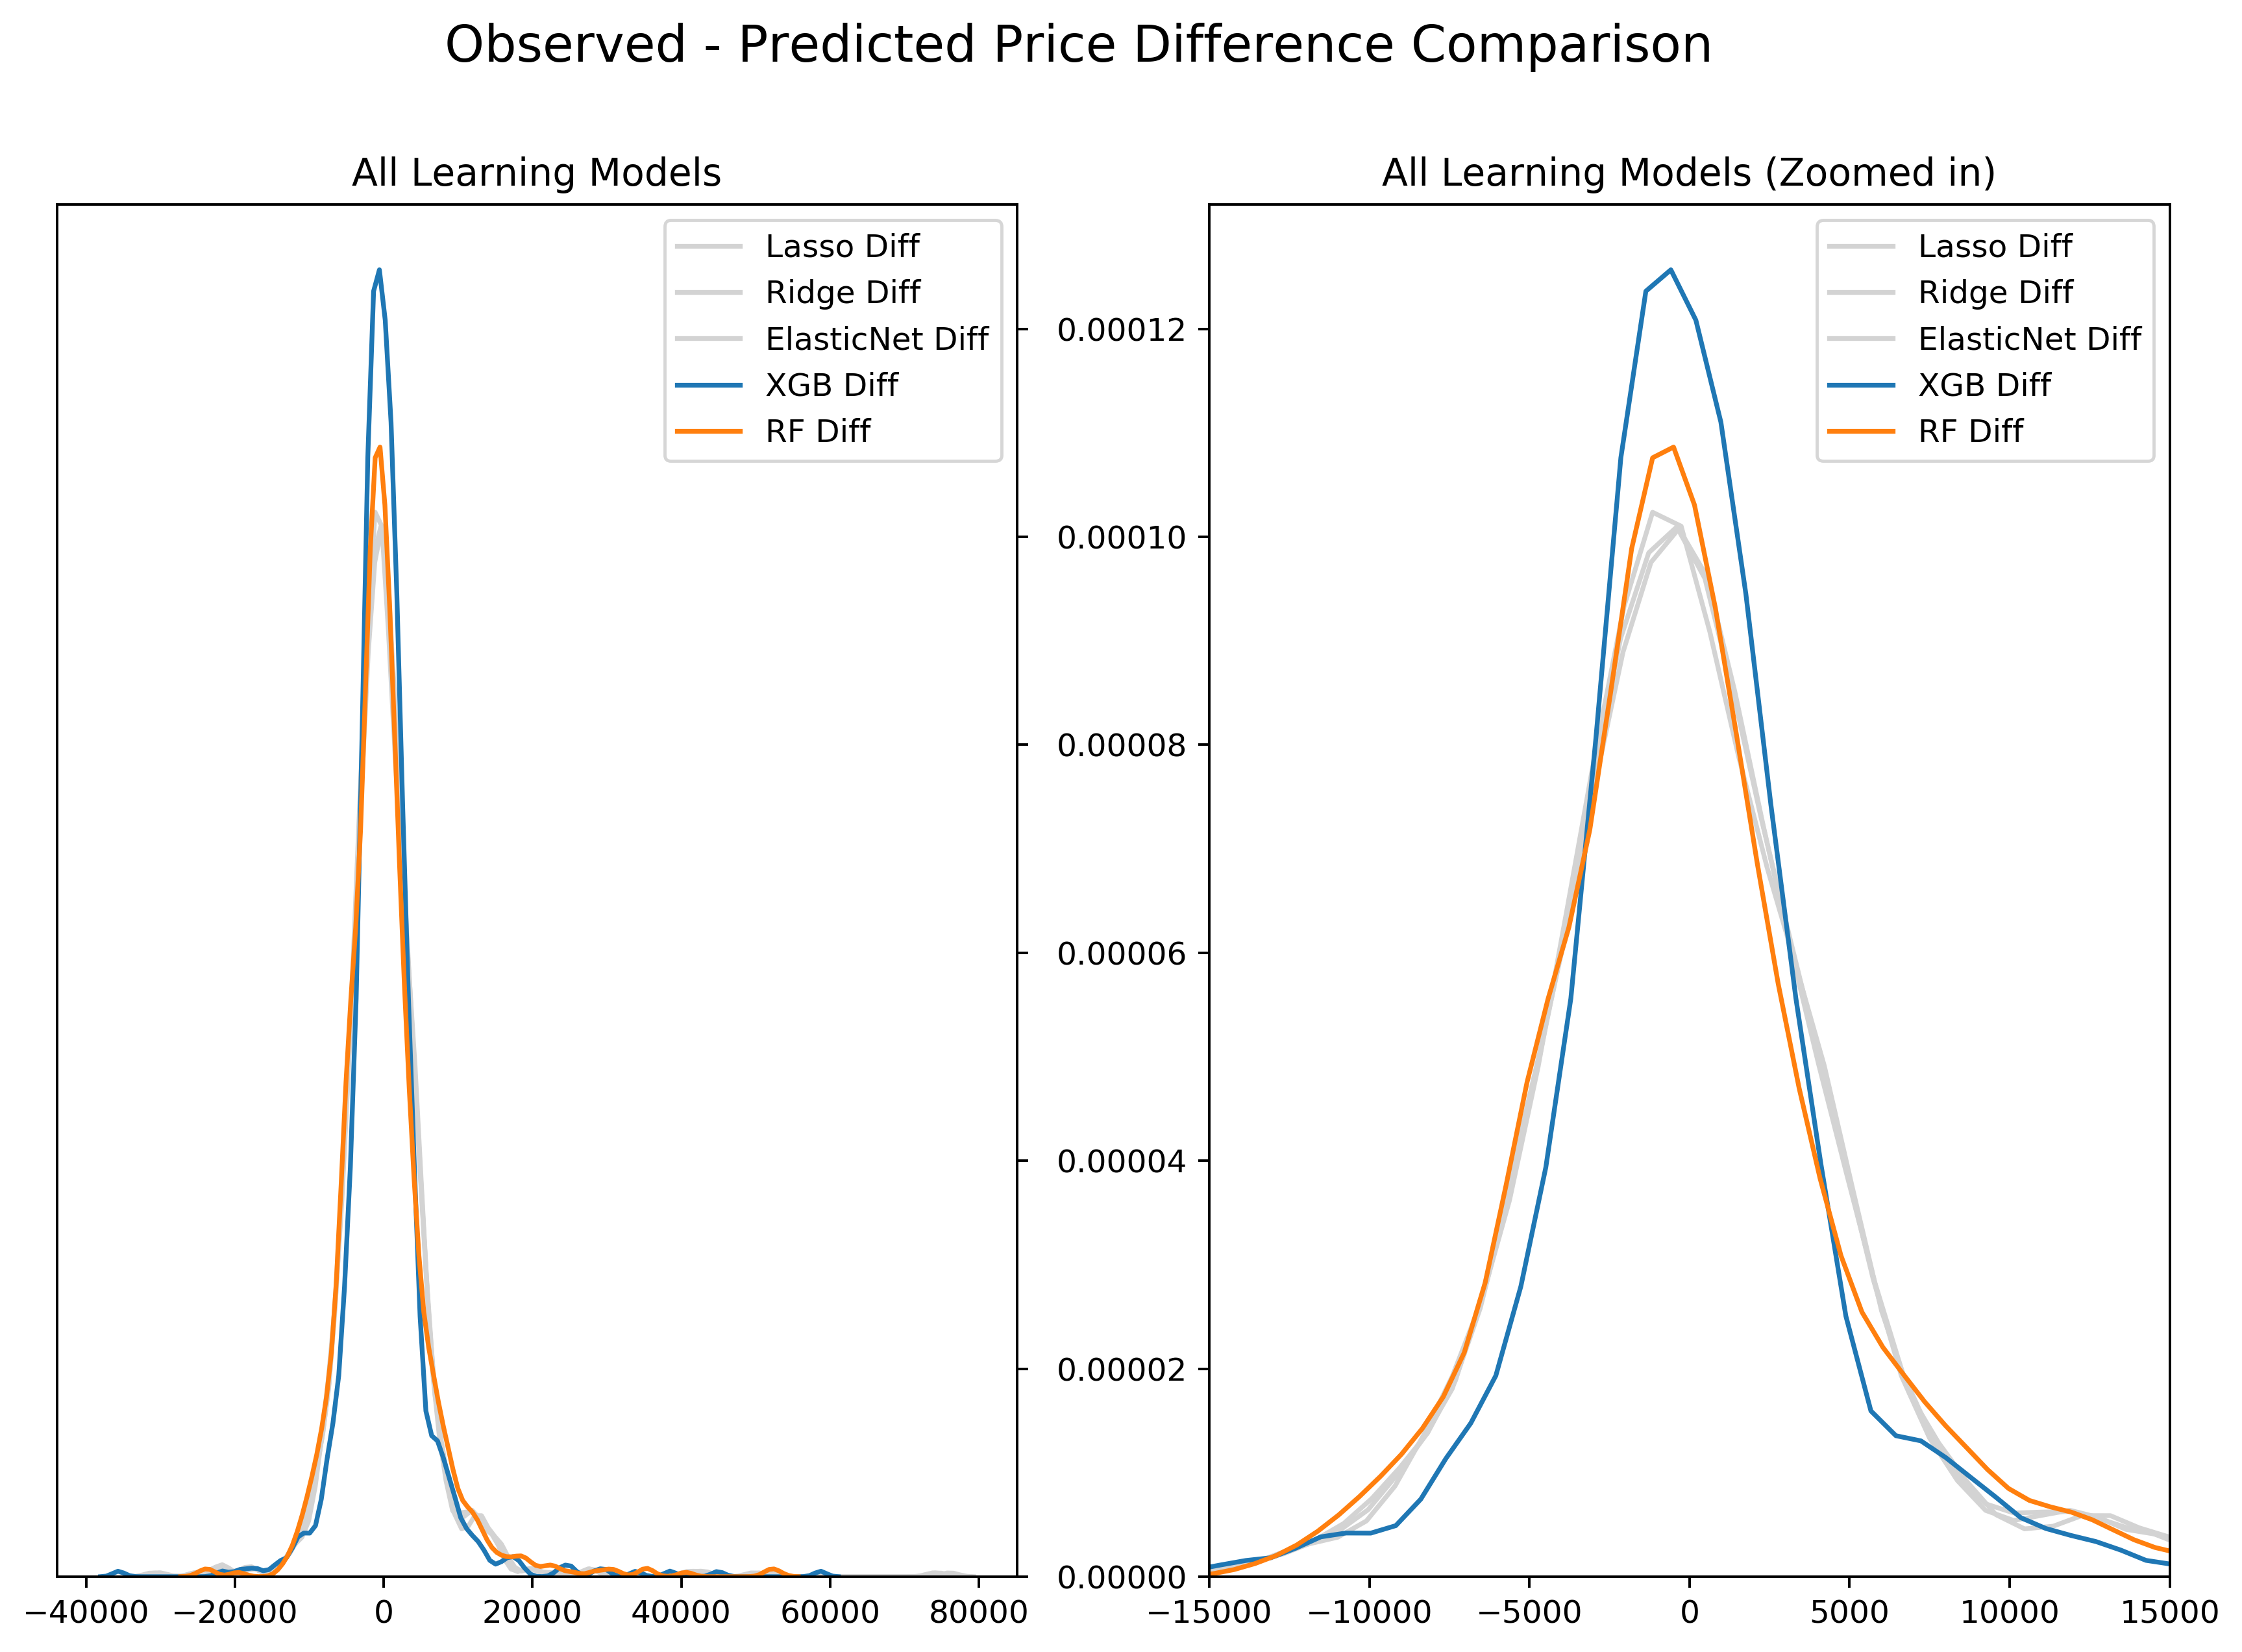

In [55]:

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8), dpi = 350)
fig.suptitle('Observed - Predicted Price Difference Comparison', fontsize=16)

ax1.set_title('All Learning Models')
sns.kdeplot(comparison['Lasso Diff'], ax=ax1, color = 'lightgray')
sns.kdeplot(comparison['Ridge Diff'], ax=ax1, color = 'lightgray')
sns.kdeplot(comparison['ElasticNet Diff'], ax=ax1, color = 'lightgray')
sns.kdeplot(comparison['XGB Diff'], ax=ax1)
sns.kdeplot(comparison['RF Diff'], ax=ax1)
ax1.set_yticklabels('')
ax1.yaxis.tick_right()


ax2.set_title('All Learning Models (Zoomed in)')
sns.kdeplot(comparison['Lasso Diff'], ax=ax2, color = 'lightgray')
sns.kdeplot(comparison['Ridge Diff'], ax=ax2, color = 'lightgray')
sns.kdeplot(comparison['ElasticNet Diff'], ax=ax2, color = 'lightgray')
sns.kdeplot(comparison['XGB Diff'], ax=ax2)
sns.kdeplot(comparison['RF Diff'], ax=ax2)
plt.xlim(-15000, 15000)
    
plt.show()

954